In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [2]:
def sigmoid(Z):
    return np.divide(1.0, 1.0 + np.exp(-Z))
def sigmoid_derivative(Z):
    S = sigmoid(Z)
    return np.multiply(S, 1.0 - S)
def tanh_derivative(Z):
    return (1.0 - np.tanh(Z)**2)
def ReLU(Z):
    return np.maximum(0, Z)
def ReLU_derivative(Z):
    return np.int64(Z > 0)
def activation(Z, activation_function_name = "sigmoid"):
    if activation_function_name == "sigmoid":
        S = sigmoid(Z)
    elif activation_function_name == "tanh":
        S = np.tanh(Z)
    elif activation_function_name == "ReLU":
        S = ReLU(Z)
    return S
def activation_derivative(Z, activation_function_name = "sigmoid"):
    if activation_function_name == "sigmoid":
        dS = sigmoid_derivative(Z)
    elif activation_function_name == "tanh":
        dS = tanh_derivative(Z)
    elif activation_function_name == "ReLU":
        dS = ReLU_derivative(Z)
    return dS
def normalize_X_Y(X, Y, X_test, Y_test):
    Xu = np.mean(X, axis = 1, keepdims = True)
    Xs = np.std(X, axis = 1, keepdims = True)
    XX = (X - Xu) / Xs
    YY = np.int64(Y > 0.5)
    XX_test = (X_test - Xu) / Xs
    if len(Y_test) != 0:
        YY_test = np.int64(Y_test > 0.5)
    else:
        YY_test = []
    return XX, Xu, Xs, YY, XX_test, YY_test
def normalize_W_b(W, b, Xu, Xs): # modified 12/30/2017
    L = len(W)
    WW = [[]] * L
    bb = [[]] * L
    WW[1] = W[1] * Xs.T
    bb[1] = b[1] + np.dot(W[1], Xu)
    for l in range(2, L):
        WW[l] = np.copy(W[l])
        bb[l] = np.copy(b[l])
    return WW, bb
def denormalize_WW_bb(WW, bb, Xu, Xs): # modified 12/30/2017
    L = len(WW)
    W = [[]] * L
    b = [[]] * L
    W[1] = WW[1] / Xs.T
    b[1] = bb[1] - np.dot(WW[1], Xu / Xs)
    for l in range(2, L):
        W[l] = np.copy(WW[l])
        b[l] = np.copy(bb[l])
    return W, b
def initialize_WW_bb(NN, hlayer_activation="ReLU"):
    L = len(NN)
    WW = [[]] * L   # 1st element is empty
    bb = [[]] * L   # 1st element is empty
    if hlayer_activation == "ReLU":
        COEFF = 2.0 # He initialization for ReLU activations
    else:
        COEFF = 1.0 # tanh activation, etc.
    for l in range(1, L):
        WW[l] = np.random.randn(NN[l], NN[l-1]) * np.sqrt(COEFF / NN[l-1])
        bb[l] = np.zeros((NN[l], 1))
    return WW, bb
def initialize_vv_ss(NN):
    L = len(NN)
    vvdW = [[]] * L   # Adam optimization
    vvdb = [[]] * L   # Adam optimization
    ssdW = [[]] * L   # Adam optimization
    ssdb = [[]] * L   # Adam optimization
    for l in range(1, L):
        vvdW[l] = np.zeros((NN[l], NN[l-1]))
        vvdb[l] = np.zeros((NN[l], 1))
        ssdW[l] = np.zeros((NN[l], NN[l-1]))
        ssdb[l] = np.zeros((NN[l], 1))
    return vvdW, vvdb, ssdW, ssdb
def forward_propagation(X, W, b, hlayer_activation, keep_prob):
    L = len(W)
    Z = [[]] * L
    A = [[]] * L
    DO = [[]] * L # drop-out regularization
    A[0] = X
    if keep_prob[0] >= 1.0:  # drop-out regularization
        DO[0] = 1
    else:
        DO[0] = np.random.rand(A[0].shape[0], A[0].shape[1]) < keep_prob[0]
        DO[0] = np.divide(DO[0] , keep_prob[0])
        A[0] = np.multiply(A[0], DO[0])
    for l in range(1, L):
        Z[l] = np.dot(W[l], A[l-1]) + b[l]
        if l < (L-1):
            A[l] = activation(Z[l], hlayer_activation)
        else:
            A[l] = activation(Z[l], "sigmoid")
        if keep_prob[l] >= 1.0:  # drop-out regularization
            DO[l] = 1
        else:
            DO[l] = np.random.rand(A[l].shape[0], A[l].shape[1]) < keep_prob[l]
            DO[l] = np.divide(DO[l] , keep_prob[l])
            A[l] = np.multiply(A[l], DO[l])
    return Z, A, DO
def backward_propagation(Y, W, A, Z, DO, hlayer_activation, L2_regularization_beta):
    m = Y.shape[1]
    L = len(W)
    dZ = [[]] * L
    dA = [[]] * L
    dW = [[]] * L
    db = [[]] * L
    dZ[-1] = (1.0/m) * (A[-1] - Y) # Sigmoid function is assumed for the last layer activation
    dZ[-1] = np.multiply(dZ[-1], DO[-1]) # drop-out regularization
    for l in reversed(range(1, L)):
        dW[l] = np.dot(dZ[l], A[l-1].T)
        if L2_regularization_beta != 0:
            dW[l] = dW[l] + (L2_regularization_beta / m) * W[l]  # L2 regularization added
        db[l] = np.sum(dZ[l], axis=1, keepdims=True)
        if l != 1:
            dA[l-1] = np.dot(W[l].T, dZ[l])
            dA[l-1] = np.multiply(dA[l-1], DO[l-1]) # drop-out regularization
            dZ[l-1] = np.multiply(dA[l-1], activation_derivative(Z[l-1], hlayer_activation))
    return dW, db
def compute_cost(Y, AL, WW, L2_regularization_beta):
    m = Y.shape[1]
    ii = (Y > 0.5)
    LOSS = np.zeros(Y.shape)
    LOSS[ii] = - np.log(AL[ii])   # Y == 1
    LOSS[~ii] = - np.log(1 - AL[~ii])   # Y == 0
    cost_l2_regularization = 0.0
    if L2_regularization_beta != 0:
        for l in range(1,len(WW)):
            cost_l2_regularization = cost_l2_regularization + (L2_regularization_beta / 2 / m) * np.sum(np.square(WW[l]))
    cost = (1/m) * np.sum(LOSS) + cost_l2_regularization
    cost = cost.squeeze()
    assert(isinstance(cost,float) or isinstance(cost,int))
    return cost
def update_WW_bb(opt_method, W, b, dW, db, vvdW, vvdb, ssdW, ssdb, learning_rate, adam_cnt, adam_beta1, adam_beta2, adam_epsilon):
    L = len(W)
    vdW_corrected = [[]] * L # Adam optimization
    vdb_corrected = [[]] * L # Adam optimization
    sdW_corrected = [[]] * L # Adam optimization
    sdb_corrected = [[]] * L # Adam optimization
    for l in range(1, L):
        if (opt_method == "momentum") or (opt_method == "adam"):
            vvdW[l] = adam_beta1 * vvdW[l] + (1 - adam_beta1) * dW[l] # Adam optimization
            vvdb[l] = adam_beta1 * vvdb[l] + (1 - adam_beta1) * db[l] # Adam optimization
            vdW_corrected[l] = vvdW[l] / (1 - adam_beta1**adam_cnt) # Adam optimization
            vdb_corrected[l] = vvdb[l] / (1 - adam_beta1**adam_cnt) # Adam optimization
        if opt_method == "adam":
            ssdW[l] = adam_beta2 * ssdW[l] + (1 - adam_beta2) * (dW[l])**2 # Adam optimization
            ssdb[l] = adam_beta2 * ssdb[l] + (1 - adam_beta2) * (db[l])**2 # Adam optimization
            sdW_corrected[l] = ssdW[l] / (1 - adam_beta2**adam_cnt) # Adam optimization
            sdb_corrected[l] = ssdb[l] / (1 - adam_beta2**adam_cnt) # Adam optimization
        #--------------------------------------------
        if opt_method == "gradient decent":
            W[l] = W[l] - learning_rate * dW[l]
            b[l] = b[l] - learning_rate * db[l]
        elif opt_method == "momentum":
            W[l] = W[l] - learning_rate * vdW_corrected[l] 
            b[l] = b[l] - learning_rate * vdb_corrected[l]    
        elif opt_method == "adam":
            W[l] = W[l] - learning_rate * vdW_corrected[l] / (np.sqrt(sdW_corrected[l]) + adam_epsilon)
            b[l] = b[l] - learning_rate * vdb_corrected[l] / (np.sqrt(sdb_corrected[l]) + adam_epsilon)
    return W, b, vvdW, vvdb, ssdW, ssdb
def predict(X, Y, W, b, hlayer_activation):
    if len(X) != 0:
        _, A, _ = forward_propagation(X, W, b, hlayer_activation, [1.0]*len(W)) # [1.0]*leng(W): turn off drop-out regularization
        Y_predict = np.int64(A[-1] > 0.5)
    else:
        Y_predict = []
    if len(Y) != 0:
        predict_accuracy = 1 - np.mean(np.abs(Y - Y_predict))
    else:
        predict_accuracy = np.nan
    return Y_predict, predict_accuracy
def plot_contour(w, b, hlayer_activation):
    # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html
    N = 100   # the number of grid points
    x = np.linspace(0,1,N)
    XV, YV = np.meshgrid(x, x)
    xy = np.array([XV.reshape(1,-1).squeeze(), YV.reshape(1,-1).squeeze()])
    zz, aa, _ = forward_propagation(xy, w, b, hlayer_activation, [1.0]*len(w)) # [1.0]*leng(w): turn off drop-out regularization
    ZY = zz[-1].reshape(XV.shape)
    # https://matplotlib.org/examples/pylab_examples/contour_demo.html
    CS = plt.contour(XV, YV, ZY, 6, colors="k", levels=[0])  # draw only zero line
    #plt.clabel(CS, fontsize=9, inline=1)
def DEBUG_gradcheck_Wb_to_vector(W, b): # modified 12/30/2017
    theta = []
    for l in range(1,len(W)):
        theta.extend(W[l].reshape(-1,1))
        theta.extend(b[l].reshape(-1,1))
    theta = np.array(theta)
    assert(theta.shape == (len(theta),1))
    return theta
def DEBUG_gradcheck_vector_to_Wb(theta, W, b):
    WW = [[]]*len(W)
    bb = [[]]*len(b)
    n = 0
    for l in range(1,len(W)):
        LEN1 = W[l].shape[0] * W[l].shape[1]
        WW[l] = theta[n:(n+LEN1)].reshape(W[l].shape)
        n = n + LEN1
        LEN2 = b[l].shape[0] * b[l].shape[1]
        bb[l] = theta[n:(n+LEN2)].reshape(b[l].shape)
        n = n + LEN2
    return WW, bb
def DEBUG_gradcheck(X, Y, W, b, hlayer_activation, L2_regularization_beta):
    epsilon = 1e-7
    theta = DEBUG_gradcheck_Wb_to_vector(W, b)
    gradapprox = np.zeros(theta.shape)
    for i in range(len(theta)):
        thetaplus = np.copy(theta)
        thetaplus[i] = thetaplus[i] + epsilon
        W1, b1 = DEBUG_gradcheck_vector_to_Wb(thetaplus, W, b)
        _, A1, _ = forward_propagation(X, W1, b1, hlayer_activation, [1]*len(W))
        Jplus = compute_cost(Y, A1[-1], W1, L2_regularization_beta)
        #-----------------------------------------------------
        thetaminus = np.copy(theta)
        thetaminus[i] = thetaminus[i] - epsilon
        W2, b2 = DEBUG_gradcheck_vector_to_Wb(thetaminus, W, b)
        _, A2, _ = forward_propagation(X, W2, b2, hlayer_activation, [1]*len(W))
        Jminus = compute_cost(Y, A2[-1], W2, L2_regularization_beta)
        #-----------------------------------------------------
        gradapprox[i] = (Jplus - Jminus) / 2 / epsilon
    Z, A, DO = forward_propagation(X, W, b, hlayer_activation, [1]*len(W))
    dW, db = backward_propagation(Y, W, A, Z, DO, hlayer_activation, L2_regularization_beta)
    grad = DEBUG_gradcheck_Wb_to_vector(dW, db)
    #---------------------------------------------------
    numerator = np.linalg.norm(gradapprox - grad, 2) # L2 norm
    denominator = np.linalg.norm(gradapprox, 2) + np.linalg.norm(grad, 2) # L2 norm
    difference = numerator / denominator
    if difference > 2e-7:
        print ("\033[93m" + ">> DEBUG: There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + ">> DEBUG: Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    return difference
def random_mini_batches(X, Y, mini_batch_size = 64):
    #np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    # Step 1: Shuffle (X, Y)
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = max(1, math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,(k*mini_batch_size):((k+1)*mini_batch_size)]
        mini_batch_Y = shuffled_Y[:,(k*mini_batch_size):((k+1)*mini_batch_size)]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    # Handling the end case (last mini-batch < mini_batch_size)
    if (m >= mini_batch_size) and (m % mini_batch_size != 0):
        mini_batch_X = shuffled_X[:,(num_complete_minibatches*mini_batch_size):]
        mini_batch_Y = shuffled_Y[:,(num_complete_minibatches*mini_batch_size):]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [3]:
def model(X, Y, X_test, Y_test, W = [], b = [], hidden_layer_dims = [], num_epochs = 2000, learning_rate = 0.001, hlayer_activation = "ReLU", 
          L2_regularization_beta = 0.0, DropOut_regularization_keep_prob = 1.0, mini_batch_size = 64, 
          opt_method = "adam", adam_beta1 = 0.9, adam_beta2 = 0.999, adam_epsilon = 1e-8):
    print("> Deep Neural Network (numpy) started ...")
    print(">> version = np-2017-12-30")
    print('>> X_train shape = '+str(X.shape))
    print('>> Y_train shape = '+str(Y.shape))
    print('>> X_test shape = '+str(X_test.shape if len(X_test)!=0 else X_test))
    print('>> Y_test shape = '+str(Y_test.shape if len(Y_test)!=0 else Y_test))
    print(">> the number of training data = " + str(X.shape[1]))
    print(">> the number of test data = " + str(X_test.shape[1] if len(X_test)!=0 else X_test))
    NN = [X.shape[0]] + hidden_layer_dims + [Y.shape[0]]
    print(">> the number of units of layers = " + str(NN))
    print(">> the number of epochs = " + str(num_epochs))
    print(">> learning rate = " + str(learning_rate))
    print(">> activation function of hidden layers = " + hlayer_activation)
    print(">> L2 regularization: beta = " + str(L2_regularization_beta))
    if isinstance(DropOut_regularization_keep_prob,float) or isinstance(DropOut_regularization_keep_prob,int):
        keep_prob = [DropOut_regularization_keep_prob] * len(NN)
    elif len(DropOut_regularization_keep_prob) == len(NN):
        keep_prob = DropOut_regularization_keep_prob
    print(">> Drop-Out regularization: keep_prob = " + str(keep_prob))
    print(">> mini batch size = " + str(mini_batch_size))
    print(">> optimization method = " + opt_method)
    print(">> Adam optimization: beta1 = " + str(adam_beta1))
    print(">> Adam optimization: beta2 = " + str(adam_beta2))
    print(">> Adam optimization: epsioin = " + str(adam_epsilon))
    #------------------------------------------------------------------------------
    XX, Xu, Xs, YY, XX_test, YY_test = normalize_X_Y(X, Y, X_test, Y_test)
    if (len(W) == 0) or (len(b) == 0):
        WW, bb = initialize_WW_bb(NN, hlayer_activation)
        print(">> W and b are intialized...")
    else:
        WW, bb = normalize_W_b(W, b, Xu, Xs)
        print(">> User-defined W and b are given and normalized...")
    vvdW, vvdb, ssdW, ssdb = initialize_vv_ss(NN)
    costs = []
    train_accuracies = []
    test_accuracies = []
    adam_cnt = 0;
    tic = time.time()
    for i in range(1, num_epochs+1):
        #seed = seed + 1
        #minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        minibatches = random_mini_batches(XX, YY, mini_batch_size)
        # minibatches = [(XX,YY)]
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            ZZ, AA, DO = forward_propagation(minibatch_X, WW, bb, hlayer_activation, keep_prob)
            cost = compute_cost(minibatch_Y, AA[-1], WW, L2_regularization_beta)
            dW, db = backward_propagation(minibatch_Y, WW, AA, ZZ, DO, hlayer_activation, L2_regularization_beta)
            adam_cnt = adam_cnt + 1
            WW, bb, vvdW, vvdb, ssdW, ssdb = update_WW_bb(opt_method, WW, bb, dW, db, vvdW, vvdb, ssdW, ssdb, learning_rate, adam_cnt, adam_beta1, adam_beta2, adam_epsilon)
        costs.append(cost)
        Yp_train, train_accuracy = predict(XX, YY, WW, bb, hlayer_activation)
        train_accuracies.append(train_accuracy)
        Yp_test, test_accuracy = predict(XX_test, YY_test, WW, bb, hlayer_activation)
        test_accuracies.append(test_accuracy)
        if (i == 1) or (i%1000 == 0) or (i == num_epochs):
            toc = time.time()
            print(">> epoch = {}; adam_count = {}; cost = {:.6f}; train_accuracy = {:.3f}; test_accuracy = {:.3f}; time = {} sec"
                  .format(i, adam_cnt, cost, train_accuracy, test_accuracy, toc-tic))
            tic = time.time()
    #------------------------------------------------------------------------------
    DEBUG_gradcheck(XX, YY, WW, bb, hlayer_activation, L2_regularization_beta) # DEBUGGING
    W, b = denormalize_WW_bb(WW, bb, Xu, Xs)
    fout = {"costs":costs,
            "train_accuracies":train_accuracies,
            "test_accuracies":test_accuracies,
            "W":W,
            "b":b,
            "Yp_train":Yp_train,
            "Yp_test":Yp_test}
    return fout

> Deep Neural Network (numpy) started ...
>> version = np-2017-12-30
>> X_train shape = (2, 700)
>> Y_train shape = (1, 700)
>> X_test shape = []
>> Y_test shape = []
>> the number of training data = 700
>> the number of test data = []
>> the number of units of layers = [2, 10, 5, 2, 1]
>> the number of epochs = 1000
>> learning rate = 0.001
>> activation function of hidden layers = ReLU
>> L2 regularization: beta = 0.0
>> Drop-Out regularization: keep_prob = [1.0, 1.0, 1.0, 1.0, 1.0]
>> mini batch size = 64
>> optimization method = adam
>> Adam optimization: beta1 = 0.9
>> Adam optimization: beta2 = 0.999
>> Adam optimization: epsioin = 1e-08
>> W and b are intialized...
>> epoch = 1; adam_count = 11; cost = 0.583704; train_accuracy = 0.894; test_accuracy = nan; time = 0.3840200901031494 sec
>> epoch = 1000; adam_count = 11000; cost = 0.022835; train_accuracy = 1.000; test_accuracy = nan; time = 18.002028226852417 sec
>> DEBUG: Your backward propagation works perfectly fine! differenc

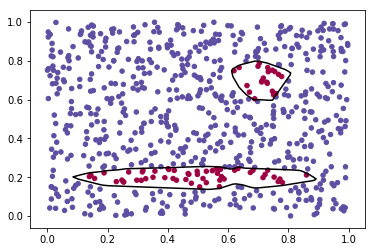

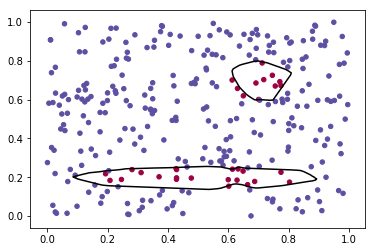

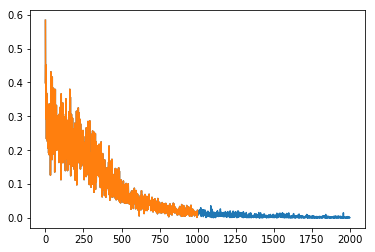

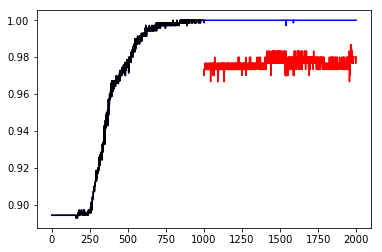

In [4]:
if True:
    M = 1000   # the number of samples
    np.random.seed(1)
    X = np.random.rand(2, M)
    Y = np.zeros((1, M))
    #Y[0, (X[1,:] - X[0,:] + 0.3) > 0 ] = 1  # line
    #Y[0, (X[0,:]**2 + X[1,:]**2 - 0.7**2) > 0 ] = 1  # semi-circle
    #Y[0, ((X[0,:]-0.5)**2 + (X[1,:]-0.5)**2 - 0.3**2) > 0] = 1  # circle
    #Y[0, (((X[0,:]-0.5)/0.4)**2 + ((X[1,:]-0.2)/0.05)**2 - 1) > 0] = 1  # ellipse
    Y[0, ((((X[0,:]-0.5)/0.4)**2 + ((X[1,:]-0.2)/0.05)**2 - 1) > 0) & (((X[0,:]-0.7)**2 + (X[1,:]-0.7)**2 - 0.1**2) > 0)] = 1  # ellipse & circle
    #-----------------------------------------------------------------
    rn = np.random.permutation(M)
    NofT = math.floor(M * 0.7) # number of train samples
    X_train = X[:,rn[0:NofT]]
    Y_train = Y[:,rn[0:NofT]]
    X_test = X[:,rn[NofT:]]
    Y_test = Y[:,rn[NofT:]]
    #-----------------------------------------------------------------
    hidden_layer_dims = [10,5,2]
    num_epochs = 1000
    learning_rate = 0.001
    hlayer_activation = ["sigmoid", "tanh", "ReLU"][2]
    L2_regularization_beta = 0.0
    DropOut_regularization_keep_prob = 1.0# [1.0, 0.7, 0.8, 0.9, 1.0]
    mini_batch_size = 64
    opt_method = ["gradient decent", "momentum", "adam"][2]
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    adam_epsilon = 1e-8
    fout1 = model(X_train, Y_train, [], [], [], [], hidden_layer_dims, num_epochs, learning_rate, hlayer_activation, L2_regularization_beta, DropOut_regularization_keep_prob, mini_batch_size, opt_method, adam_beta1, adam_beta2, adam_epsilon)
    fout2 = model(X_train, Y_train, X_test, Y_test, fout1["W"], fout1["b"], hidden_layer_dims, num_epochs, learning_rate, hlayer_activation, L2_regularization_beta, DropOut_regularization_keep_prob, mini_batch_size, opt_method, adam_beta1, adam_beta2, adam_epsilon)
    #-----------------------------------------------------------------
    %matplotlib inline
    plt.scatter(X_train[0,:], X_train[1,:], c=Y_train, s=20, cmap=plt.cm.Spectral)
    plot_contour(fout2["W"], fout2["b"], hlayer_activation)    # user-defined plot
    plt.show()
    plt.scatter(X_test[0,:], X_test[1,:], c=Y_test, s=20, cmap=plt.cm.Spectral)
    plot_contour(fout2["W"], fout2["b"], hlayer_activation)    # user-defined plot
    plt.show()
    plt.plot(fout1["costs"] + fout2["costs"])
    plt.plot(fout1["costs"])
    plt.show()
    plt.plot(fout1["train_accuracies"] + fout2["train_accuracies"],'b-')
    plt.plot(fout1["train_accuracies"],'k-')
    plt.plot(fout1["test_accuracies"] + fout2["test_accuracies"],'r-')
    plt.plot(fout1["test_accuracies"],'k-')
    plt.show()